In [1]:
# following
# https://towardsdatascience.com/custom-loss-function-in-tensorflow-2-0-d8fa35405e4e

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as kb
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
def sReLU(x, x0=1):
    """
    page 4 of 1910.11710
    """
    return relu(-(x-x0)) * relu(x)

def sReLU2(x):
    return sReLU(x)**2

def sReLU3(x):
    return sReLU(x)**3

def sReLUn(x, n):
    """
    generalisation of sReLU. Raises sReLU to the power n.
    """
    return sReLU(x)**n

from tensorflow import keras
from tensorflow.keras import layers

class sReLU_Layer(layers.Layer):
    def __init__(self, initializer="he_normal", **kwargs):
        super(sReLU_Layer, self).__init__(**kwargs)
        self.initializer = keras.initializers.get(initializer)

    # def build(self, input_shape):
    #     output_dim = input_shape[-1]
    #     self.kernel = self.add_weight(
    #         shape=(output_dim * 2, output_dim),
    #         initializer=self.initializer,
    #         name="kernel",
    #         trainable=True,
    #     )

    def call(self, inputs):
        return tf.nn.relu(-(inputs-1)) * tf.nn.relu(inputs)

    def get_config(self):
        # Implement get_config to enable serialization. This is optional.
        base_config = super(sReLU_Layer, self).get_config()
        config = {"initializer": keras.initializers.serialize(self.initializer)}
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
# high level example
# https://github.com/sol0invictus/Blog_stuff/blob/master/custom%20loss/high_level_keras.py

In [6]:
# custom loss
def custom_loss(y_actual, y_pred):
    """
    always two args.
    must be tensors
    
    must return scalar tensor
    """
    
    loss = kb.square(y_actual - y_pred)
    return loss

In [7]:
# custom loss
def custom_loss_mean(y_actual, y_pred):
    """
    always two args.
    must be tensors
    
    must return scalar tensor
    """
    
    loss = tf.reduce_mean(tf.square(y_actual - y_pred))
    return loss

In [8]:
# custom loss
def custom_loss_max(y_actual, y_pred):
    """
    always two args.
    must be tensors
    
    must return scalar tensor
    """
    
    loss = tf.reduce_max(tf.square(y_actual - y_pred))
    return loss

In [1382]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(200, activation='tanh', input_shape=[1]),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(200, activation='tanh'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(200, activation='tanh'),
    tf.keras.layers.Dense(1)
    
])

# sReLU_Layer()

In [1383]:
keras_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 200)               400       
_________________________________________________________________
dense_77 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_78 (Dense)             (None, 200)               10200     
_________________________________________________________________
dense_79 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_80 (Dense)             (None, 200)               10200     
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 201       
Total params: 41,101
Trainable params: 41,101
Non-trainable params: 0
_________________________________________________

In [1384]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=100, min_lr=1e-8)

In [1385]:
# https://www.tensorflow.org/api_docs/python/tf/keras/experimental/CosineDecayRestarts
first_decay_steps = 20
lr_decayed_fn = (
  tf.keras.experimental.CosineDecayRestarts(
      0.001,
      first_decay_steps,
      t_mul=2.,
      m_mul=1
  ))

lr_scheuler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

In [1386]:
# decay_steps = 500
# lr_decayed_fn = (
#   tf.keras.experimental.LinearCosineDecay(
#     0.001, decay_steps))

# lr_scheuler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

In [1387]:
# decay_steps = 1000
# lr_decayed_fn = (
#   tf.keras.experimental.NoisyLinearCosineDecay(
#     0.001, decay_steps))

# lr_scheuler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

In [1388]:
# optimizer = tf.keras.optimizers.RMSprop(0.001)
optimizer = tf.keras.optimizers.Adam(0.001)
# keras_model.compile(loss=custom_loss, optimizer=optimizer)
keras_model.compile(loss=custom_loss_mean, optimizer=optimizer)
# keras_model.compile(loss=custom_loss_max, optimizer=optimizer)

In [1389]:
# # sample data
# x = tf.range(1, 11, dtype=tf.float32)[:, tf.newaxis].numpy()
# y = x**2

In [1390]:
# x = np.linspace(0, 1, 1000)[:, np.newaxis]
# y = np.sin(x/0.2)

In [1391]:
def gen_test_data():
#     x = np.linspace(-np.pi/2., np.pi/2., 100)
#     x = np.linspace(-1, 1, 200)[:,np.newaxis]
    x = np.linspace(0., 0.5, 200)[:,np.newaxis]
    y = np.cos(50*x) + np.sin(10*x)
#     y = np.cos(50*x) + np.sin(5*x)
    return x, y

x, y = gen_test_data()


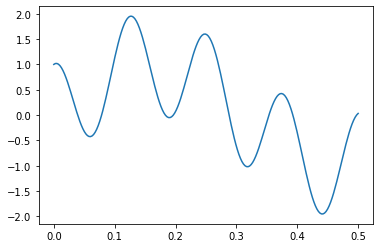

In [1392]:
plt.figure()
plt.plot(x, y)

In [ ]:
%%time
# history = keras_model.fit(x, y, batch_size=10, epochs=1000, callbacks=[reduce_lr])
history = keras_model.fit(x, y, batch_size=x.shape[0], epochs=5000, callbacks=[lr_scheuler])

Epoch 1/5000
1/1 [==============================] - 0s 971us/step - loss: 1.0249 - lr: 0.0010
Epoch 2/5000
1/1 [==============================] - 0s 1ms/step - loss: 1.0068 - lr: 9.9384e-04
Epoch 3/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.9894 - lr: 9.7553e-04
Epoch 4/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.9703 - lr: 9.4550e-04
Epoch 5/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.9476 - lr: 9.0451e-04
Epoch 6/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.9216 - lr: 8.5355e-04
Epoch 7/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.8918 - lr: 7.9389e-04
Epoch 8/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.8589 - lr: 7.2700e-04
Epoch 9/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.8248 - lr: 6.5451e-04
Epoch 10/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.7907 - lr: 5.7822e-04
Epoch 11/5000
1/1 [======================

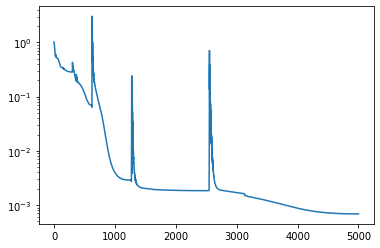

In [1394]:
loss = history.history['loss']
plt.figure()
plt.plot(range(len(loss)), loss)
plt.yscale('log')

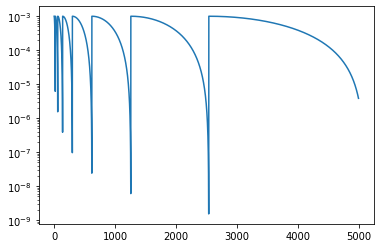

In [1395]:
lr = history.history['lr']
plt.figure()
plt.plot(range(len(lr)), lr)
plt.yscale('log')

In [1396]:
keras_model.predict([2])

array([[21.39578]], dtype=float32)

In [1397]:
keras_model.predict(x);

In [1398]:
keras_model.evaluate(x, y)

7/7 [==============================] - 0s 904us/step - loss: 6.8576e-04


0.0006857637199573219

In [1399]:
custom_loss(y, keras_model.predict(x));

In [1400]:
custom_loss_mean(y, keras_model.predict(x))

<tf.Tensor: shape=(), dtype=float64, numpy=0.0006857637810949147>

In [1401]:
tf.reduce_sum(custom_loss(y, keras_model.predict(x)))

<tf.Tensor: shape=(), dtype=float64, numpy=0.13715275621898293>

In [1402]:
custom_loss_mean(y, keras_model.predict(x))

<tf.Tensor: shape=(), dtype=float64, numpy=0.0006857637810949147>

In [1403]:
custom_loss_max(y, keras_model.predict(x))

<tf.Tensor: shape=(), dtype=float64, numpy=0.01736553314566439>

In [1404]:
# x_new = np.arange(1, 10.1, 0.1)[:, np.newaxis]
# x_new = np.arange(1, 1.1, 0.1)[:, np.newaxis]
# x_new = np.arange(-1, 1., 0.0001)[:, np.newaxis]
x_new = np.arange(0, 0.5, 0.0001)[:, np.newaxis]

In [1405]:
yhat = keras_model.predict(x_new)

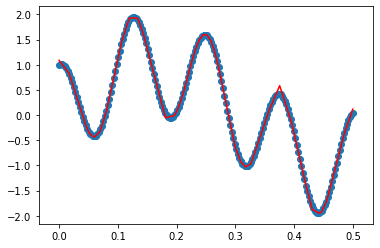

In [1406]:
plt.figure()
plt.scatter(x, y)
plt.plot(x_new, yhat, 'r')

(0, 0.5)

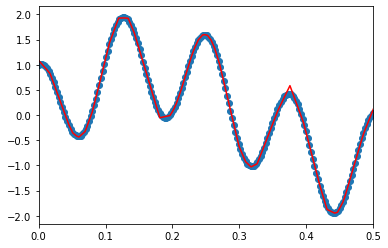

In [1407]:
plt.figure()
plt.scatter(x, y)
plt.plot(x_new, yhat, 'r')
plt.xlim(0, 0.5)

In [1408]:
# y_32 = custom_loss(y, keras_model.predict(x))

In [1409]:
x.shape

(200, 1)

In [1410]:
y.shape

(200, 1)

(1e-16, 1)

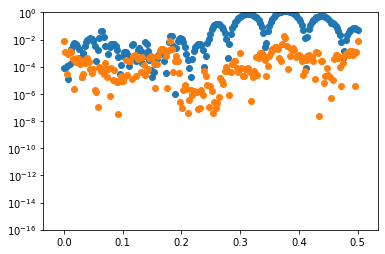

In [1411]:
plt.figure()
plt.scatter(x, y_32)
plt.scatter(x, custom_loss(y, keras_model.predict(x)))
plt.yscale('log')
plt.ylim(1e-16, 1)